In [1]:
import numpy as np
import xarray as xr
import pandas as pd

import ecco_v4_py as ecco

import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


### Import ECCO dataset

In [2]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r3_output/').rename({'face': 'tile'})

### Useful quantities

In [3]:
# Density kg/m^3
rhoconst = 1029

# m^3 to Sverdrup
Sv = 10**-6

### Define the section lines 

In [4]:
pt1,pt2 = ecco.get_section_endpoints('Denmark Strait')
maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)

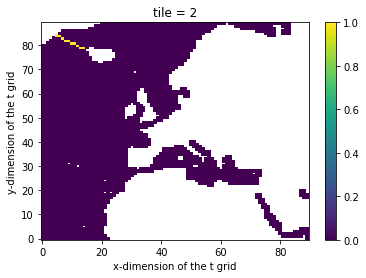

In [5]:
maskC[2].where(main.hFacC[0,2].values==1).plot()

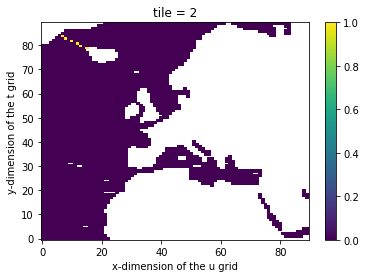

In [6]:
maskW[2].where(main.hFacW[0,2].values==1).plot()

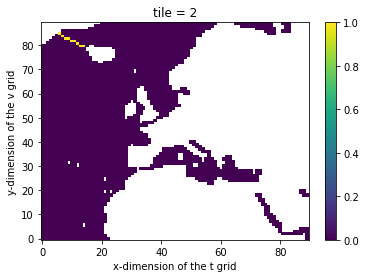

In [7]:
maskS[2].where(main.hFacS[0,2].values==1).plot()

### Grid area along section

**$X$**: ds.UVELMASS
`hFacW`, `maskW`
- Tile 2: zonal
- Tile 6: meridional
- Tile 10: meridional

**$Y$**: ds.VVELMASS
`hFacS`, `maskS`
- Tile 2: meridional
- Tile 6: zonal
- Tile 10: zonal

In [8]:
# Cell area along y at u location (m^2)
dyA = main.dyG*main.drF*main.hFacW

# Cell area along x at v location (m^2)
dxA = main.dxG*main.drF*main.hFacS

In [9]:
# Get area for Davis Strait
dyA_FrS = dyA*maskW
dxA_FrS = dxA*maskS

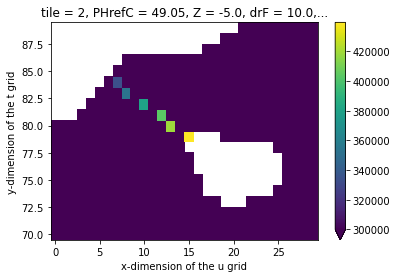

In [10]:
dyA_FrS[2,:,:,0].where(main.hFacW[0,2].values==1)[70:,:30].plot(vmin=3.0e5)

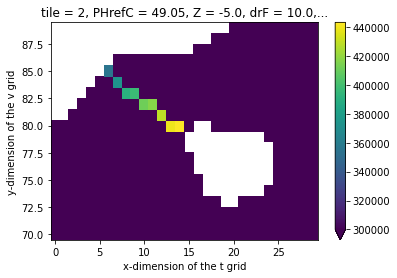

In [11]:
dxA_FrS[2,:,:,0].where(main.hFacS[0,2].values==1)[70:,:30].plot(vmin=3.0e5)

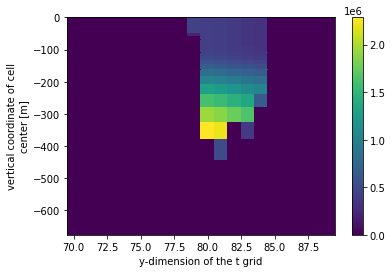

In [12]:
dyA_FrS.sum(dim=['i_g','tile'])[70:,:25].T.swap_dims({'k':'Z'}).plot()

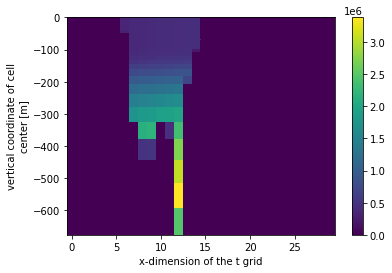

In [13]:
dxA_FrS.sum(dim=['j_g','tile'])[:30,:25].T.swap_dims({'k':'Z'}).plot()

In [14]:
sec_area_x = dyA_FrS.sum(dim=['i_g','j','tile'])
sec_area_y = dxA_FrS.sum(dim=['i','j_g','tile'])

In [15]:
# Section area (m^2)
sec_area = (sec_area_x + sec_area_y).sum('k').compute()

print('Area across the strait:',np.round(sec_area.values/1e6),'km^2')

Area across the strait: 180.0 km^2


### Volume flux

In [16]:
#u_transport = main['UVELMASS'] * main['drF'] * main['dyG']
#v_transport = main['VVELMASS'] * main['drF'] * main['dxG']

u_transport = (main['UVELMASS'] + main['UVELSTAR']) * main['drF'] * main['dyG']
v_transport = (main['VVELMASS'] + main['VVELSTAR']) * main['drF'] * main['dxG']

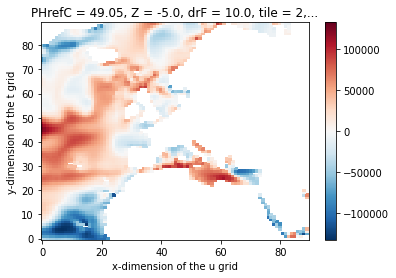

In [17]:
u_transport[:,0,2].mean('time').where(main.hFacW[0,2].values==1).plot()

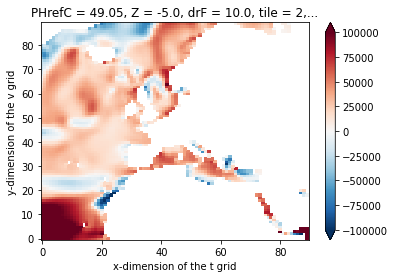

In [18]:
v_transport[:,0,2].mean('time').where(main.hFacS[0,2].values==1).plot(vmin=-1e5)

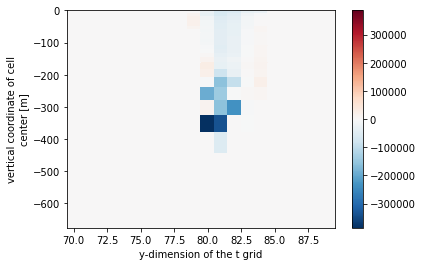

In [19]:
(u_transport * maskW).sum(dim=['i_g','tile']).mean('time')[:25,70:].swap_dims({'k':'Z'}).plot()

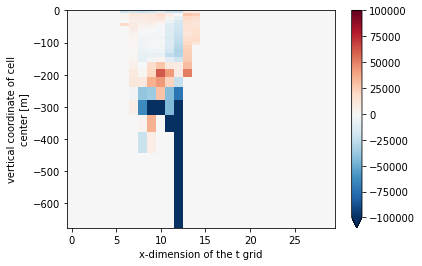

In [20]:
(v_transport * maskS).sum(dim=['j_g','tile']).mean('time')[:25,:30].swap_dims({'k':'Z'}).plot(vmin=-1e5)

In [21]:
# Volume transports
sec_trsp_x = (u_transport * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (v_transport * maskS).sum(dim=['i','j_g','tile'])

In [22]:
sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv
#sec_trsp = sec_trsp.sel(time=slice('1993-01-01','2015-12-31'))

print('Vol. flux (1992-2015):', 
      np.round(sec_trsp.mean('time').values,1),'±',np.round(2*sec_trsp.std('time').values,1),'Sv')

Vol. flux (1992-2015): -5.4 ± 2.6 Sv


### Calculate freshwater fluxes

In [23]:
# Reference salinity
Sref = 34.8
#Sref = 35.0

In [24]:
grid = ecco.get_llc_grid(main)

In [25]:
SALT_at_u = grid.interp(main.SALT, 'X', boundary='extend')
SALT_at_v = grid.interp(main.SALT, 'Y', boundary='extend')

In [27]:
# Freshwater advective (Eulerian+Bolus) fluxes (m^3/s)
ADVx_FW = (main.UVELMASS+main.UVELSTAR)*main.dyG*main.drF*(Sref-SALT_at_u)/Sref
ADVy_FW = (main.VVELMASS+main.VVELSTAR)*main.dxG*main.drF*(Sref-SALT_at_v)/Sref

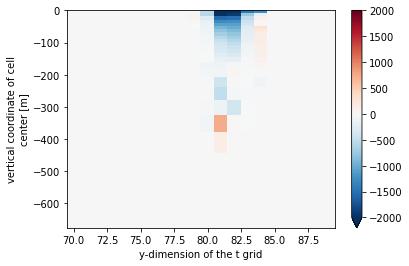

In [28]:
(ADVx_FW * maskW).sum(dim=['i_g','tile']).mean('time')[:25,70:].swap_dims({'k':'Z'}).plot(vmin=-2000)

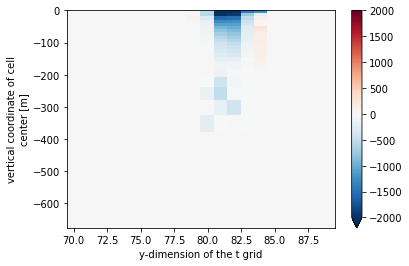

In [30]:
(ADVx_FW.where(SALT_at_u.values<=Sref)*maskW).sum(dim=['i_g','tile']).mean('time')[:25,70:]\
            .swap_dims({'k':'Z'}).plot(vmin=-2000)

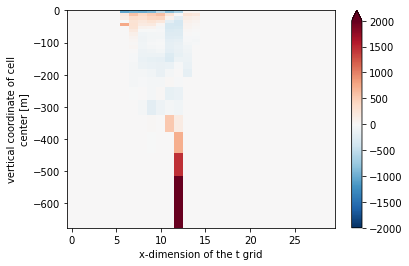

In [29]:
(ADVy_FW * maskS).sum(dim=['j_g','tile']).mean('time')[:25,:30].swap_dims({'k':'Z'}).plot(vmin=-2000)

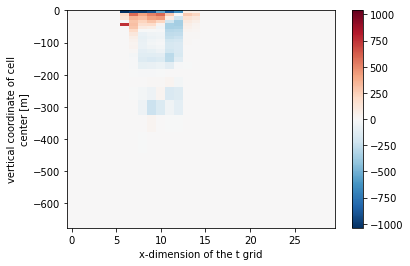

In [31]:
(ADVy_FW.where(SALT_at_v.values<=Sref)*maskS).sum(dim=['j_g','tile']).mean('time')[:25,:30]\
            .swap_dims({'k':'Z'}).plot()#vmin=-2000)

In [32]:
# Full-depth integration
#sec_trsp_x = (ADVx_FW * maskW).sum(dim=['i_g','j','tile'])
#sec_trsp_y = (ADVy_FW * maskS).sum(dim=['i','j_g','tile'])

# Integration from isohaline
sec_trsp_x = (ADVx_FW.where(SALT_at_u.values<=Sref) * maskW).sum(dim=['i_g','j','tile'])
sec_trsp_y = (ADVy_FW.where(SALT_at_v.values<=Sref) * maskS).sum(dim=['i','j_g','tile'])

In [33]:
# Freshwater transport (Sv)
sec_FWtrsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()*Sv
#sec_FWtrsp = sec_FWtrsp.sel(time=slice('1993-01-01','2015-12-31'))

#print('FW flux (Sref =',Sref, '/ full-depth integration','/ 1992-2015):', 
#      np.round(sec_FWtrsp.mean('time').values*1e3,1),'±',np.round(2*sec_FWtrsp.std('time').values*1e3,1),'mSv')
print('FW flux (Sref =',Sref, '/ integration from isohaline','/ 1992-2015):', 
      np.round(sec_FWtrsp.mean('time').values*1e3,1),'±',np.round(2*sec_FWtrsp.std('time').values*1e3,1),'mSv')

FW flux (Sref = 34.8 / integration from isohaline / 1992-2015): -41.4 ± 42.2 mSv


FW flux (Sref = 34.8 / full-depth integration / 1992-2015): -31.1 ± 41.0 mSv


FW flux (Sref = 35.0 / full-depth integration / 1992-2015): -62.0 ± 53.1 mSv
